# Semestrální práce
### Základem této práce jsou data eurostatu

### 1) Načtení dat a zobrazení první časové řady
##### Prvním krokem bylo načtení dat a zobrazení časové řady, abych se lépe seznámil s charakterem a chováním časové řady.

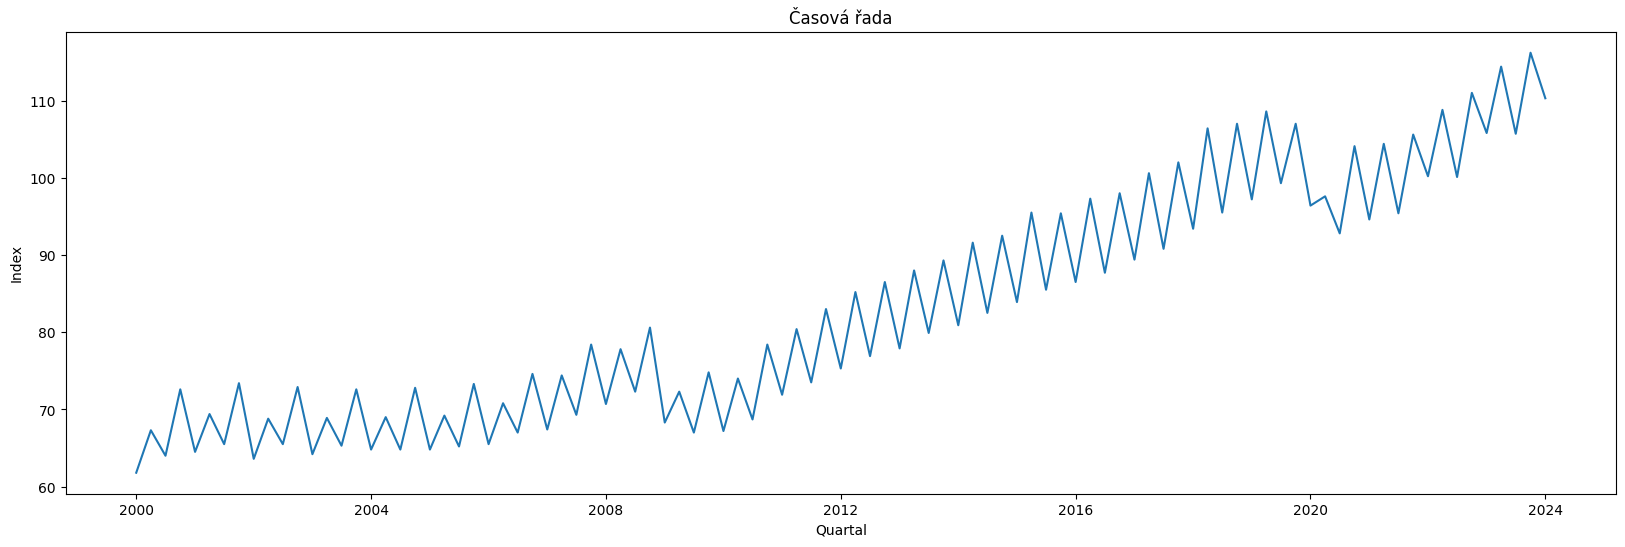

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


# Načtení dat z CSV souboru
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']



plt.figure(figsize=(20, 6))
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.title("Časová řada")
plt.plot(x,y)



##### Po zobrazení časové řady si můžeme všimnout, že v různých obdobích se chování liší:
- První čeho si všímám - každá změna je jeden kvartál
    - Každý sudý vrchol je narůst a každý lichý je pokles, tedy data vypadají, že budou mít sezónní složku
- 2000-2004 -> Zde vidíme už okem, že se hodnoty přiliš nemění
- 2004-2008 -> Zde hodnoty začínají lehce stoupat
- 2008-2010 -> Zde došlu k většímu poklesu, než je obvyklé v předchozích obdobích
- 2010-2020 -> Zde až k roku 2020 hodnoty stále stoupají v podobném stylu
- 2020-konec -> Dochází k "výraznějšímu" poklesu a následně zase hodnoty stoupají

##### Trend se mi nezdá lineární, ale v následujícím kroku se na to podíváme detailněji

### 2) Dekompozice a identifikace trendu
##### Dekompozice časové řady slouží k rozkladu na tři hlavní složky (Trendová, sezónní a náhodná)

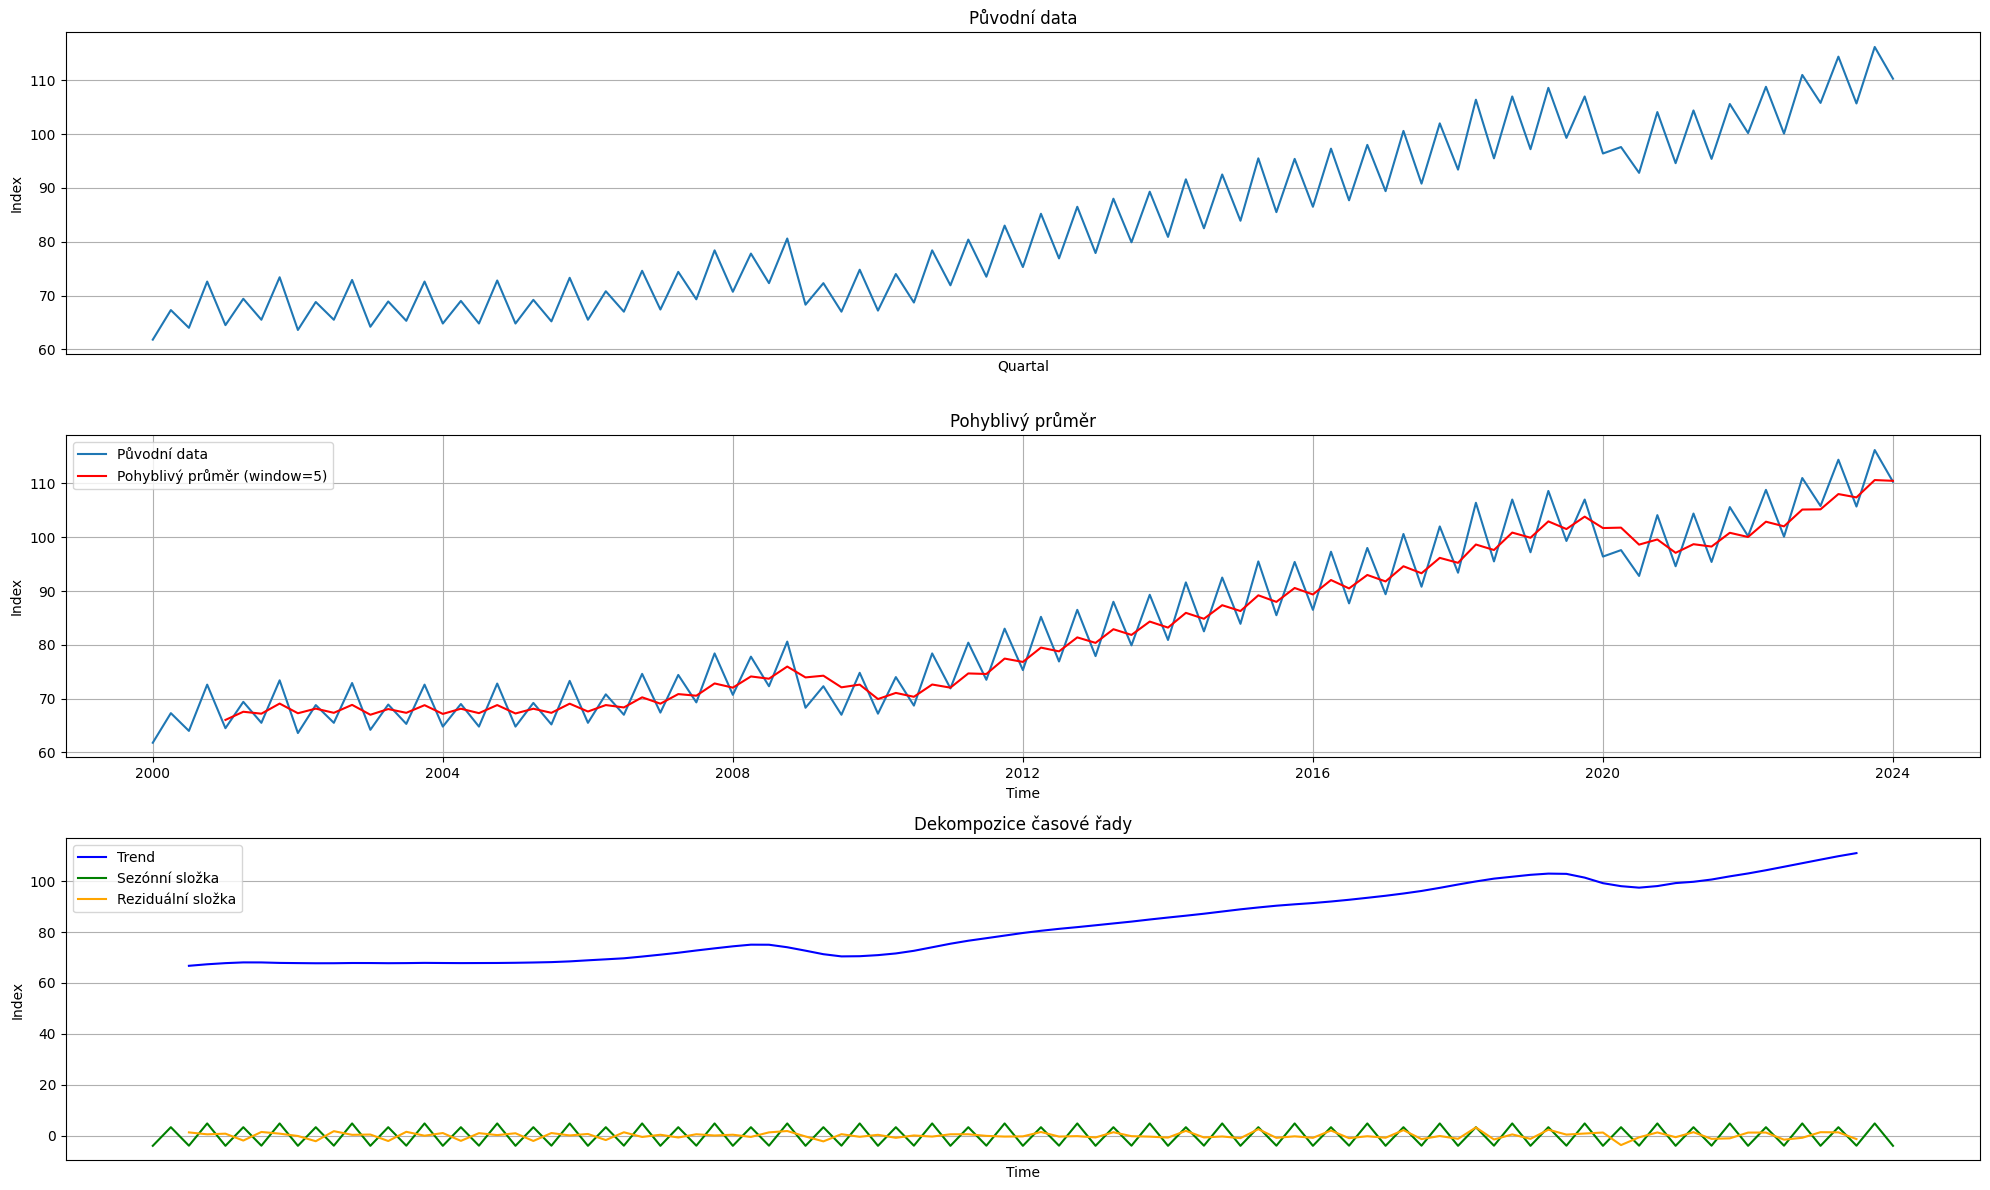

In [38]:
filtered_data['TIME_PERIOD'] = pd.to_datetime(filtered_data['TIME_PERIOD'])

# Nastavení sloupce s časem jako index
filtered_data.set_index('TIME_PERIOD', inplace=True)

# Ujistěte se, že data jsou seřazena podle času
filtered_data = filtered_data.sort_index()

# Výběr sloupce s hodnotami
data_values = filtered_data['OBS_VALUE']  # Upravte podle skutečného názvu sloupce s hodnotami

# Proveďte dekompozici
decomposition = seasonal_decompose(data_values, model='additive')

# Výpočet klouzavého průměru
window_size = 5
filtered_data['moving_average'] = filtered_data['OBS_VALUE'].rolling(window=window_size).mean()

# Zobrazení grafu
plt.figure(figsize=(20, 12))

# Původní data
plt.subplot(3, 1, 1)
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.title('Původní data')
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.xticks([])  # Odstranění hodnot na ose x
plt.grid(True)

# Trend a klouzavý průměr
plt.subplot(3, 1, 2)
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], linestyle='-', label='Původní data')
plt.plot(filtered_data.index, filtered_data['moving_average'], linestyle='-', color='red', label=f'Pohyblivý průměr (window={window_size})')
plt.title('Pohyblivý průměr')
plt.ylabel('Index')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

# Dekompozice
plt.subplot(3, 1, 3)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.plot(decomposition.seasonal, label='Sezónní složka', color='green')
plt.plot(decomposition.resid, label='Reziduální složka', color='orange')
plt.title('Dekompozice časové řady')
plt.ylabel('Index')
plt.xlabel('Time')
plt.xticks([])  # Odstranění hodnot na ose x
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

##### Yt = Tt + St + Rt
##### MAt = (Yt-2 + Yt-1 + Yt + Yt+1 + Yt+2)/5

### Trend
##### Po dekompozici vidíme, že trendová složka je nelineární, ale z mého pohledu je stále stoupající až na občasné výkyvy.
### Sezónnost
#### Dle funkce, kterou zobrazuje sezónní složka se zdá, že data mají opravdu sezónní složku, která má tendenci v lichých bodech klesat a v sudých bodech stoupat (Sudá a Lichá záleží od toho, kde začneme)
### Náhodná složka
##### I tato složka se vyskytuje, ačkoliv velmi málo



### 3) Hledání optimálního modelu pro časovou řadu
##### Dle poznatků, ke kterým jsem došel v předchozích bodech si myslím, že nejvhdonější model pro modelování a predikci bude SARIMA, jelikož se zde vyskytuje sezónnost

##### Ale pojďme vyzkoušet k čemu dojdeme při modelování

#### a) Lineární regrese

##### Lineární regrese je jeden z nejjednoduších přístupů a používá se jako jeden z prvních kroků k získání chování trendu

##### Pro determinaci validity modelu využijeme koeficient determinace, který určuje hodnoty od 0-1, přicemž 1 je nejlepší možná hodnota. Tato hodnota se tvoří pomocí metody nejmenších čtverců.

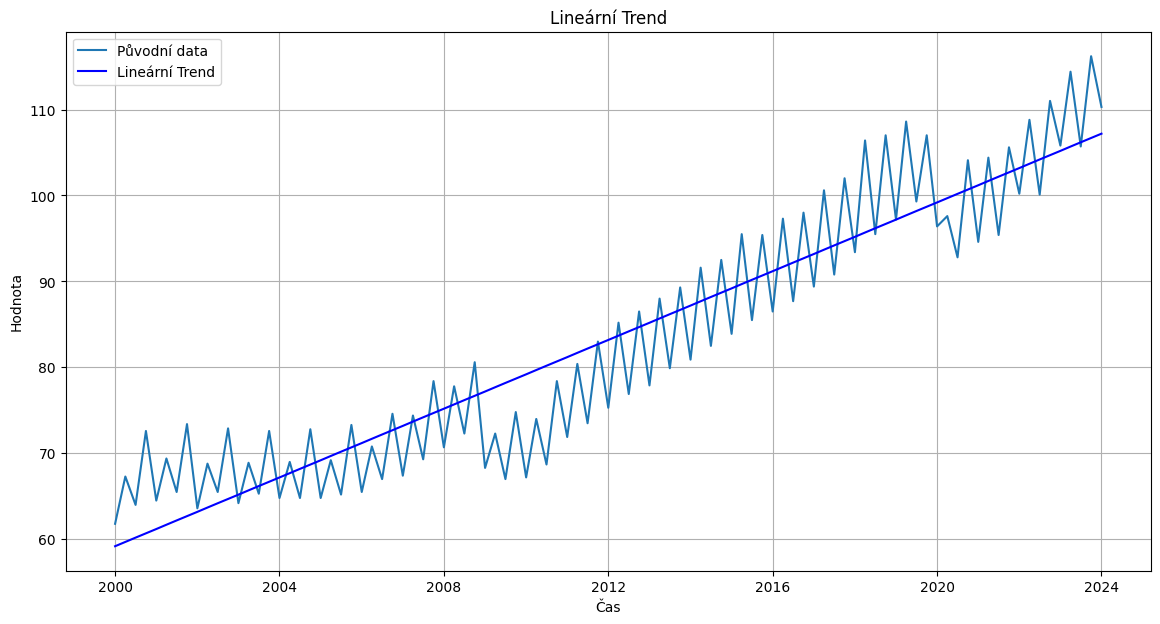

Koeficient Determinace (R²): 0.8601


In [48]:
filtered_data['Time'] = np.arange(len(filtered_data))

model = LinearRegression()
model.fit(filtered_data[['Time']], filtered_data['OBS_VALUE'])
filtered_data['Trend'] = model.predict(filtered_data[['Time']])

plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(filtered_data.index, filtered_data['Trend'], color='blue', label='Lineární Trend')
plt.title('Lineární Trend')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Zhodnocení modelu
r_squared = r2_score(filtered_data['OBS_VALUE'], filtered_data['Trend'])
print(f'Koeficient Determinace (R²): {r_squared:.4f}')


Yt = B0 + B1 * t

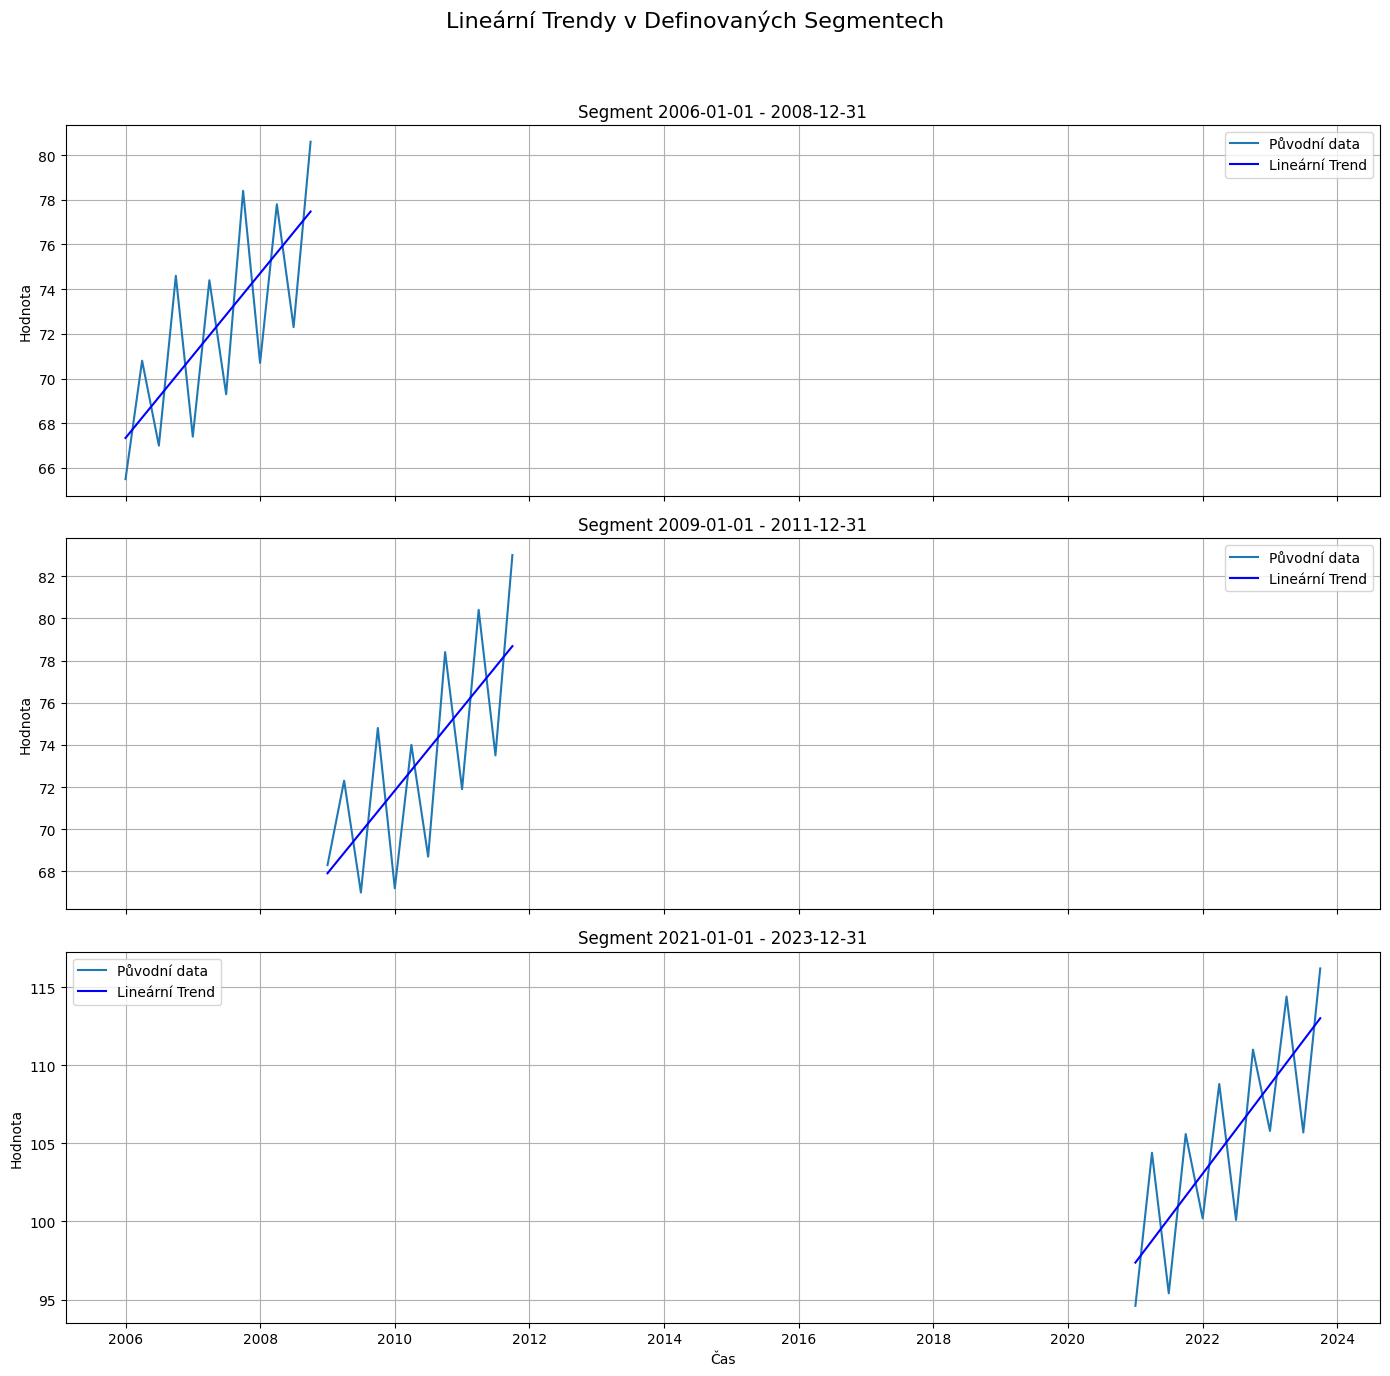

Koeficient Determinace (R²) Segmentu 1 (2006-01-01 - 2008-12-31): 0.4705
Koeficient Determinace (R²) Segmentu 2 (2009-01-01 - 2011-12-31): 0.4582
Koeficient Determinace (R²) Segmentu 3 (2021-01-01 - 2023-12-31): 0.5644


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Definování vlastních časových segmentů (zadej podle časových řad v datasetu)
# Tyto časové úseky lze přizpůsobit tvým konkrétním potřebám
segments_definitions = [
    ('2006-01-01', '2008-12-31'),  # První segment
    ('2009-01-01', '2011-12-31'),  # Druhý segment
    ('2021-01-01', '2023-12-31'),  # Třetí segment
]

# Filtrování dat do segmentů
segments = [filtered_data.loc[start:end] for start, end in segments_definitions]

# Příprava figure s 3 podgrafy
fig, axs = plt.subplots(len(segments), 1, figsize=(14, 14), sharex=True)
fig.suptitle('Lineární Trendy v Definovaných Segmentech', fontsize=16)

# Modelování trendu pro každý segment a vykreslení
for i, segment in enumerate(segments):
    # Přidání sloupce 'Time' jako číselné hodnoty pro lineární regresi
    segment['Time'] = pd.to_numeric(segment.index)
    
    # Fitování lineárního modelu
    model = LinearRegression()
    model.fit(segment[['Time']], segment['OBS_VALUE'])
    segment['Trend'] = model.predict(segment[['Time']])
    
    # Vykreslení původních dat a trendu
    axs[i].plot(segment.index, segment['OBS_VALUE'], label='Původní data')
    axs[i].plot(segment.index, segment['Trend'], color='blue', label='Lineární Trend')
    axs[i].set_title(f'Segment {segments_definitions[i][0]} - {segments_definitions[i][1]}')
    axs[i].set_ylabel('Hodnota')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Čas')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle
plt.show()

# Zhodnocení modelů pomocí R²
r_squared_values = []
for i, segment in enumerate(segments):
    r_squared = r2_score(segment['OBS_VALUE'], segment['Trend'])
    r_squared_values.append(r_squared)
    print(f'Koeficient Determinace (R²) Segmentu {i + 1} ({segments_definitions[i][0]} - {segments_definitions[i][1]}): {r_squared:.4f}')

##### Po zobrazení trendu a vypsání hodnoty R**2 si dovolím potvrdit, že trend je opravdu vzestupný a můžeme tomu věřit. 

#### b) ARIMA

##### V tomto kroku si vyzkoušíme predikovat hodnoty pomocí ARIMA modelu, který by ale dle vlastností modelu neměl být užit, jelikož se v našich datech objevuje sezónní složka. 

##### Pro zhodnocení modelu využijeme AIC a BIC, které zhodnocují kvalitu i složitost modelu. Zde naopak chceme dosáhnout co nejmenších hodnot.

###### Nižší hodnota AIC naznačuje lepší model, protože model minimalizuje ztrátu informací.

###### Nižší hodnota BIC také signalizuje lepší model, ale penalizace za složitost modelu je silnější než u AIC.


|   iter    |  target   |     d     |     p     |     q     |
-------------------------------------------------------------
| 1         | -407.2    | 2.085     | 3.602     | 0.0005719 |
| 2         | -681.0    | 1.512     | 0.7338    | 0.4617    |
| 3         | -617.3    | 0.9313    | 1.728     | 1.984     |
| 4         | -423.0    | 2.694     | 2.096     | 3.426     |
| 5         | -403.3    | 1.022     | 4.391     | 0.1369    |
| 6         | -475.5    | 3.352     | 2.087     | 2.793     |
| 7         | -601.5    | 0.7019    | 0.9905    | 4.004     |
| 8         | -489.8    | 4.841     | 1.567     | 3.462     |
| 9         | -517.9    | 4.382     | 4.473     | 0.4252    |
| 10        | -601.5    | 0.1953    | 0.8492    | 4.391     |
| 11        | -397.4    | 2.889     | 3.852     | 4.483     |
| 12        | -407.0    | 1.726     | 5.0       | 2.568     |
| 13        | -416.5    | 0.3027    | 5.0       | 5.0       |
| 14        | -451.4    | 5.0       | 5.0       | 5.0       |
| 15    

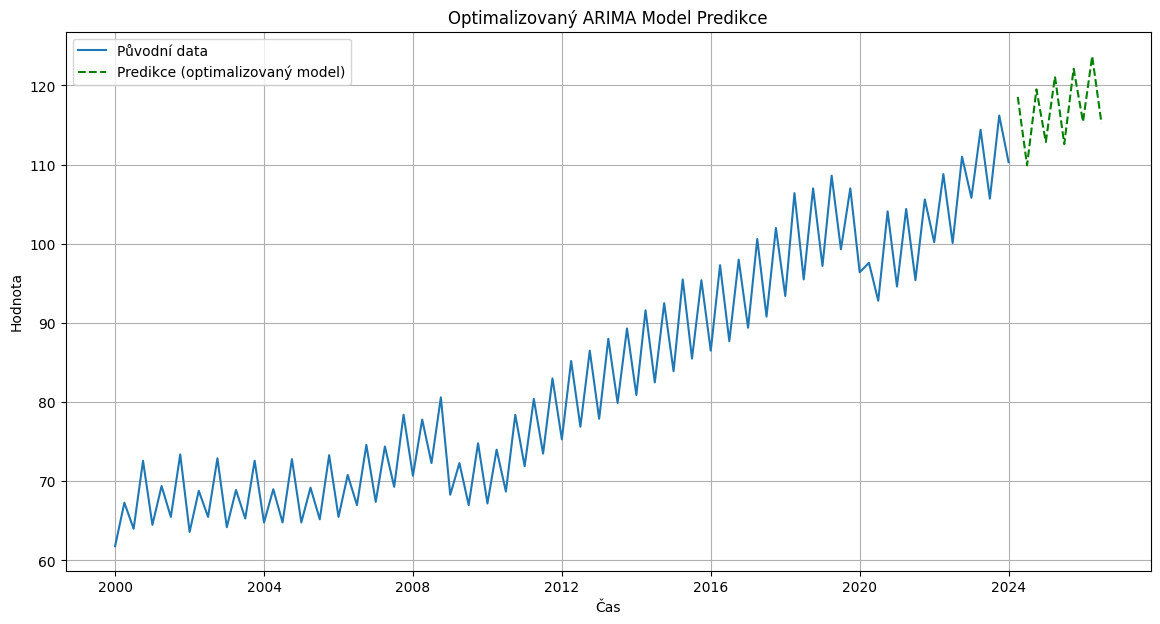

AIC: 397.4205004850135
BIC: 417.8515156178178

Koeficienty modelu:
ar.L1    -1.001422
ar.L2    -0.967517
ar.L3    -0.964249
ma.L1    -0.123227
ma.L2     0.006950
ma.L3    -0.208174
ma.L4    -0.581968
sigma2    2.943298
dtype: float64


In [81]:
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

forecast_periods = 10
# Funkce pro hodnocení ARIMA modelu (AIC jako metrika)
def evaluate_arima_model(data, p, d, q):
    try:
        # Převod parametrů na celočíselné hodnoty
        p, d, q = int(p), int(d), int(q)
        
        # Vytvoření a fitování ARIMA modelu
        model = ARIMA(data, order=(p, d, q))
        model_fit = model.fit()
        
        # Návrat hodnoty AIC
        return -model_fit.aic  # Optimalizujeme na minimum, takže vracíme zápornou hodnotu
    except:
        return np.inf  # Pokud model selže, vracíme nekonečno

# Definování rozsahu parametrů
pbounds = {
    'p': (0, 5),
    'd': (0, 5),
    'q': (0, 5)
}

# Spuštění Bayesian Optimization
optimizer = BayesianOptimization(
    f=lambda p, d, q: evaluate_arima_model(filtered_data['OBS_VALUE'], p, d, q),
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

# Spuštění optimalizace (např. 50 pokusů)
optimizer.maximize(init_points=10, n_iter=40)

# Nejlepší nalezené parametry
best_params = optimizer.max['params']
p_best = int(best_params['p'])
d_best = int(best_params['d'])
q_best = int(best_params['q'])

print(f'Nejlepší parametry ARIMA: p={p_best}, d={d_best}, q={q_best}')

# Trénink modelu ARIMA s optimalizovanými parametry
best_model = ARIMA(filtered_data['OBS_VALUE'], order=(p_best, d_best, q_best))
best_model_fit = best_model.fit()

# Vytvoření predikcí
forecast = best_model_fit.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=filtered_data.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='Q')

# Vykreslení výsledků
plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(forecast_index, forecast, color='green', linestyle='--', label='Predikce (optimalizovaný model)')
plt.title('Optimalizovaný ARIMA Model Predikce')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Zobrazení AIC a BIC pro optimalizovaný model
print(f'AIC: {best_model_fit.aic}')
print(f'BIC: {best_model_fit.bic}')

print('\nKoeficienty modelu:')
print(best_model_fit.params)

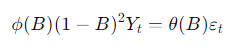
​
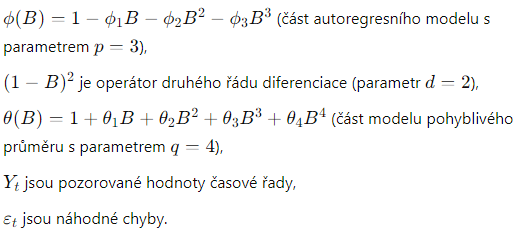


##### Po modelování a predikci okem vidíme, že hodnoty stále sotupají, ale už ne tolik jako předtím. 

##### Hodnoty:
- AIC: 403
- BIC: 421

#### 4) Použití SARIMA modelu

##### V dalším kroku využijeme SARIMA modelu, který už bere v potaz sezónní složku

##### Kritéria pro vyhodnocení budou zase AIC a BIC

|   iter    |  target   |     D     |     P     |     Q     |     d     |     p     |     q     |     s     |
-------------------------------------------------------------------------------------------------------------
| 1         | -470.9    | 2.089     | 0.8584    | 0.6806    | 1.654     | 2.158     | 1.269     | 4.0       |
| 2         | -391.8    | 2.054     | 1.443     | 1.176     | 1.03      | 2.187     | 1.316     | 4.0       |
| 3         | -382.6    | 1.194     | 2.214     | 0.5475    | 0.5264    | 1.595     | 1.595     | 4.0       |
| 4         | -389.0    | 2.548     | 2.173     | 1.833     | 2.167     | 0.9689    | 1.085     | 4.0       |
| 5         | -400.5    | 0.8811    | 1.893     | 0.2763    | 1.301     | 1.293     | 1.481     | 4.0       |
| 6         | -463.5    | 0.9368    | 1.279     | 2.68      | 2.832     | 1.506     | 1.872     | 4.0       |
| 7         | -416.0    | 0.9519    | 1.244     | 2.599     | 0.7514    | 1.449     | 2.957     | 4.0       |
| 8       

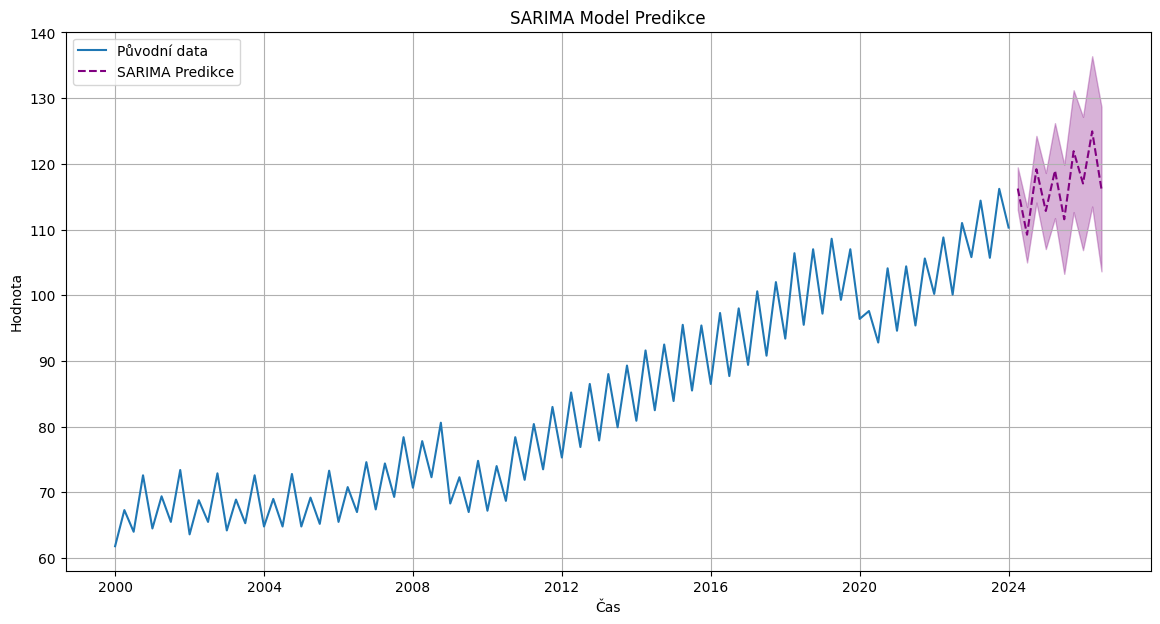

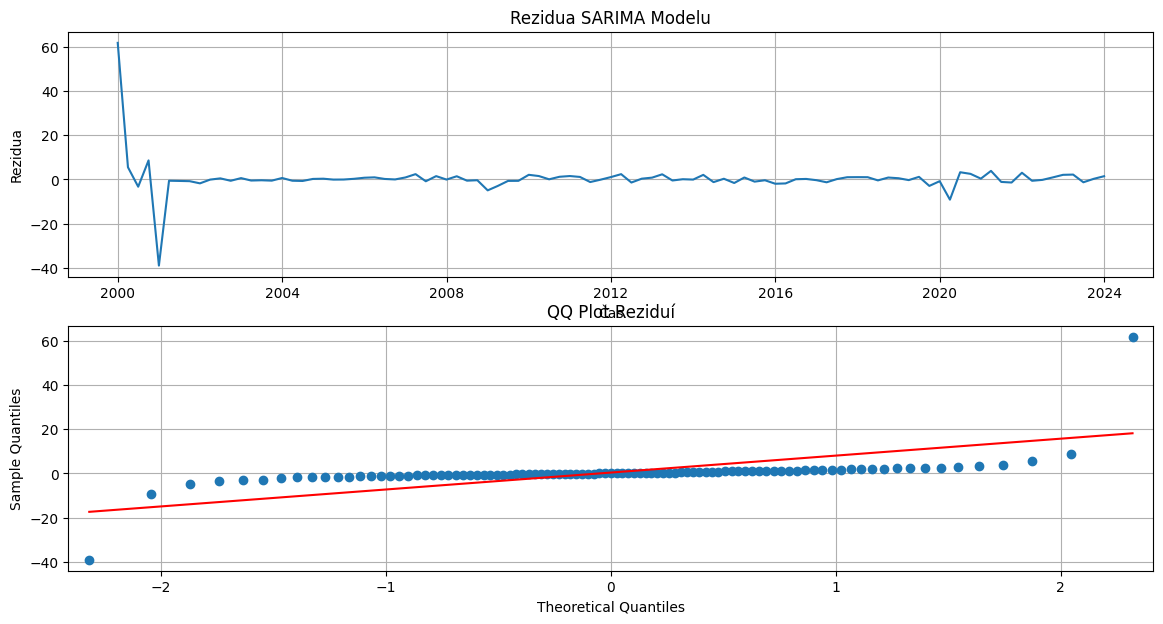

AIC: 373.68577902890524
BIC: 388.8165104911995

Koeficienty modelu:
ar.L1     -0.151568
ar.S.L4    0.673838
ar.S.L8   -0.692245
ma.S.L4   -1.241764
ma.S.L8    0.998991
sigma2     2.515284
dtype: float64


In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def evaluate_sarima_model(data, p, d, q, P, D, Q, s):
    order = (int(p), int(d), int(q))
    seasonal_order = (int(P), int(D), int(Q), int(s))
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        aic = model_fit.aic
        return -aic  # BayesianOptimization minimalizuje funkci, proto vracíme negativní AIC
    except Exception as e:
        print(f"Chyba při trénování modelu SARIMA s parametry {order} a {seasonal_order}: {e}")
        return np.nan

# Definuj rozsahy hyperparametrů
pbounds = {
    'p': (0, 3),
    'd': (0, 3),
    'q': (0, 3),
    'P': (0, 3),
    'D': (0, 3),
    'Q': (0, 3),
    's': (4, 4)  # Pokud je sezónní cyklus fixní, jinak specifikuj rozmezí
}

# Bayesian optimization
optimizer = BayesianOptimization(
    f=lambda p, d, q, P, D, Q, s: evaluate_sarima_model(filtered_data['OBS_VALUE'], p, d, q, P, D, Q, s),
    pbounds=pbounds,
    verbose=2,
    random_state=123
)

optimizer.maximize(init_points=10, n_iter=100)

# Nejlepší parametry
best_params = optimizer.max['params']
print(f'Nejlepší parametry: {best_params}')

# Trénování SARIMA modelu s nejlepšími parametry
best_order = (int(best_params['p']), int(best_params['d']), int(best_params['q']))
best_seasonal_order = (int(best_params['P']), int(best_params['D']), int(best_params['Q']), int(best_params['s']))

sarima_model = SARIMAX(
    filtered_data['OBS_VALUE'],
    order=best_order,
    seasonal_order=best_seasonal_order
)
sarima_model_fit = sarima_model.fit()

# Predikce s SARIMA modelem
sarima_forecast = sarima_model_fit.get_forecast(steps=10)
sarima_forecast_index = pd.date_range(start=filtered_data.index[-1] + pd.DateOffset(months=1), periods=10, freq='Q')
sarima_forecast_conf_int = sarima_forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, color='purple', linestyle='--', label='SARIMA Predikce')
plt.fill_between(sarima_forecast_index, sarima_forecast_conf_int.iloc[:, 0], sarima_forecast_conf_int.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMA Model Predikce')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Rezidua a QQ plot
residuals = sarima_model_fit.resid
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Rezidua SARIMA Modelu')
plt.xlabel('Čas')
plt.ylabel('Rezidua')
plt.grid(True)

plt.subplot(2, 1, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('QQ Plot Reziduí')
plt.grid(True)
plt.show()

print(f'AIC: {sarima_model_fit.aic}')
print(f'BIC: {sarima_model_fit.bic}')

# Výpis koeficientů modelu
print('\nKoeficienty modelu:')
print(sarima_model_fit.params)

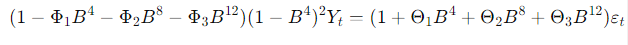

In [10]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson test statistic: {dw_stat}')

from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk test p-hodnota: {shapiro_test.pvalue}')

from statsmodels.stats.diagnostic import acorr_ljungbox
i = 1
for i in range(i,25):
    lb_test = acorr_ljungbox(residuals, lags=[i], return_df=True)
    print(lb_test)

Durbin-Watson test statistic: 1.3361519045535868
Shapiro-Wilk test p-hodnota: 6.862420856317103e-19
    lb_stat  lb_pvalue
1  0.000044   0.994696
    lb_stat  lb_pvalue
2  0.001762    0.99912
    lb_stat  lb_pvalue
3  0.368804   0.946609
     lb_stat  lb_pvalue
4  18.029049   0.001218
     lb_stat  lb_pvalue
5  18.036552   0.002901
     lb_stat  lb_pvalue
6  18.054724   0.006097
     lb_stat  lb_pvalue
7  18.071924    0.01165
     lb_stat  lb_pvalue
8  18.139092   0.020208
     lb_stat  lb_pvalue
9  18.139425    0.03359
      lb_stat  lb_pvalue
10  18.146388   0.052544
      lb_stat  lb_pvalue
11  18.153144   0.078094
      lb_stat  lb_pvalue
12  18.153651   0.111104
      lb_stat  lb_pvalue
13  18.153681   0.151771
      lb_stat  lb_pvalue
14  18.153835   0.199864
     lb_stat  lb_pvalue
15  18.16368   0.254158
      lb_stat  lb_pvalue
16  18.166623   0.314231
      lb_stat  lb_pvalue
17  18.172011   0.378068
      lb_stat  lb_pvalue
18  18.181126   0.443782
      lb_stat  lb_pvalue
1

##### Jak vidíme po výpisu, tak dle hodnot AIC a BIC by tento model měl být lepší, což potvrzuje vhodnost modelu. 

##### Hodnoty:
- AIC: 373
- BIC: 386


##### Tedy dle mého názoru je zde optimální model SARIMA

# 5) Kroskorelace a srovnání modelů

##### V posledním kroku provedeme kroskorelaci pro různé státy, abychom zjistili, zda jsou různé časové řady navzájem propojené.

##### Pomocí kroskorelace můžeme zjistit, zda změny v jedné časové řadě ovlivňují změny v druhé časové řadě a jaký časový posun má největší vliv

##### Následně provedeme srovnání modelů pro různé státy.

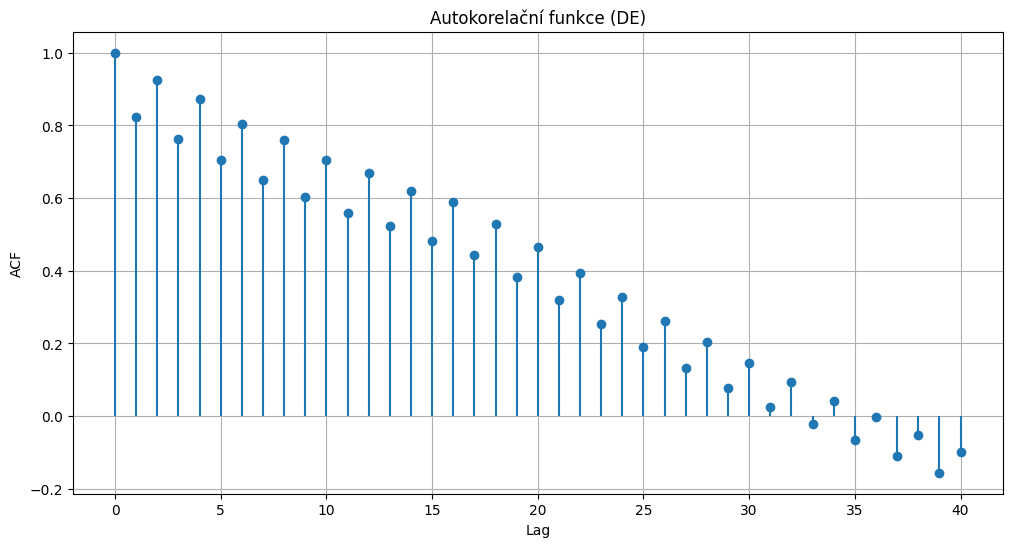

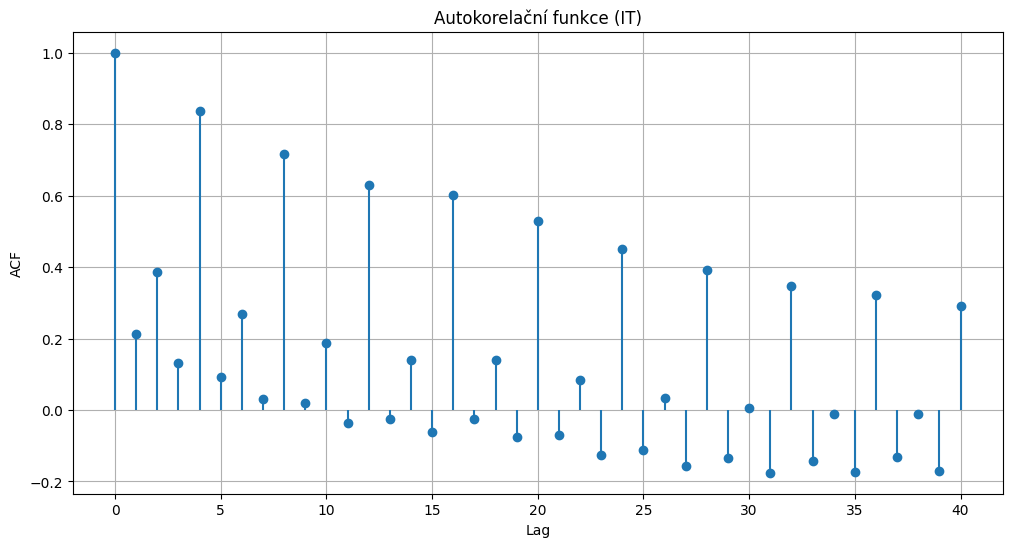

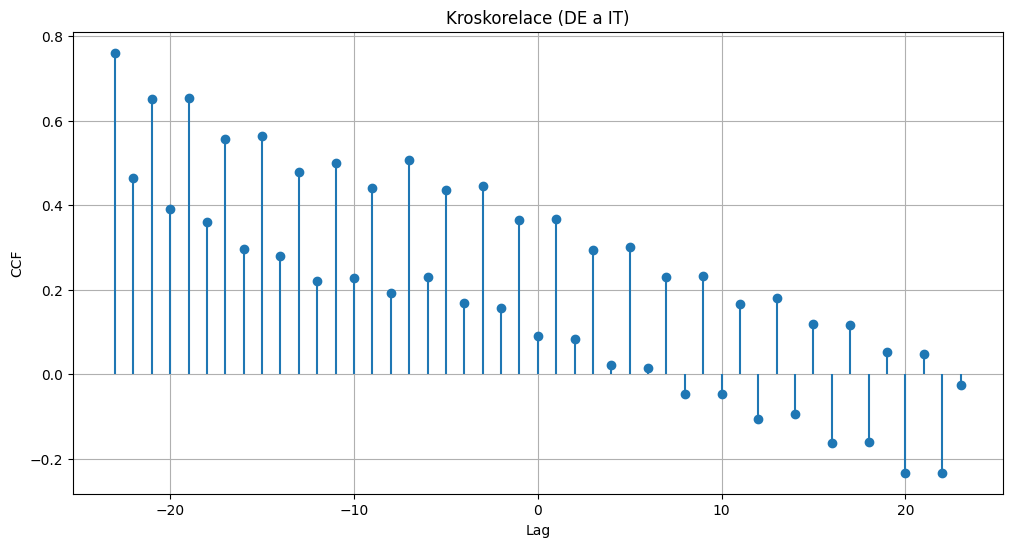

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Načtení původních dat
data = pd.read_csv('ei_isind_q_linear.csv')

data.index.freq = 'Q'

# Seznam geografických označení, které chcete analyzovat
geos = ['DE', 'IT']  # Změněno na DE a IT

# Načtení a sloučení dat pro všechny geografické oblasti
all_filtered_data = []
for geo in geos:
    filtered_data = data.loc[
        (data['unit'] == 'I21') & 
        (data['geo'] == geo) & 
        (data['s_adj'] == 'NSA') & 
        (data['indic_bt'] == 'WAGE') & 
        (data['nace_r2'] == 'C')
    ].copy()  # Použití copy(), aby se zabránilo varování
    filtered_data.loc[:, 'geo'] = geo  # Použití .loc pro přiřazení
    all_filtered_data.append(filtered_data)

combined_data = pd.concat(all_filtered_data)

# Převedení TIME_PERIOD na datetime
combined_data['TIME_PERIOD'] = pd.to_datetime(combined_data['TIME_PERIOD'])

# Pivotování dat na formát, který umožňuje analýzu
pivot_data = combined_data.pivot(index='TIME_PERIOD', columns='geo', values='OBS_VALUE')

# Výpočet autokorelační funkce (ACF)
def plot_acf(series, title):
    acf_values = acf(series, nlags=40)  # Zvolíme počet lagů
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf_values)), acf_values, basefmt=" ")
    plt.title(f'Autokorelační funkce ({title})')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.grid(True)
    plt.show()

# Výpočet kroskorelační funkce (CCF)
def plot_ccf(series1, series2, max_lag, title):
    ccf_values = compute_ccf(series1, series2, max_lag)
    plt.figure(figsize=(12, 6))
    plt.stem(range(-max_lag, max_lag + 1), ccf_values, basefmt=" ")
    plt.title(f'Kroskorelace ({title})')
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    plt.grid(True)
    plt.show()

# Funkce pro výpočet kroskorelace
def compute_ccf(series1, series2, max_lag):
    common_dates = series1.index.intersection(series2.index)
    series1 = series1.loc[common_dates]
    series2 = series2.loc[common_dates]
    ccf_values = ccf(series1, series2)
    return ccf_values[:2 * max_lag + 1]

# Autokorelační funkce pro DE a IT
for geo in geos:
    series = pivot_data[geo].dropna()
    plot_acf(series, geo)

# Kroskorelace mezi DE a IT
series_de = pivot_data['DE'].dropna()
series_it = pivot_data['IT'].dropna()
plot_ccf(series_de, series_it, max_lag=23, title='DE a IT')

##### Dle kroskorelace vidíme, že největší vztah:
- pro DE a FR/IT -> zpoždění -20
- pro FR a IT -> zpoždění v -20

##### Z výpisu vidíme jak se oproti sobě liší skutečná data a ARIMA/SARIMA model, na vizualizaci není moc vidět jaký model je lepší, ale hodnoty SARIMA/ARIMA AIC a BIC jsou vždy lepší pro SARIMA model. 

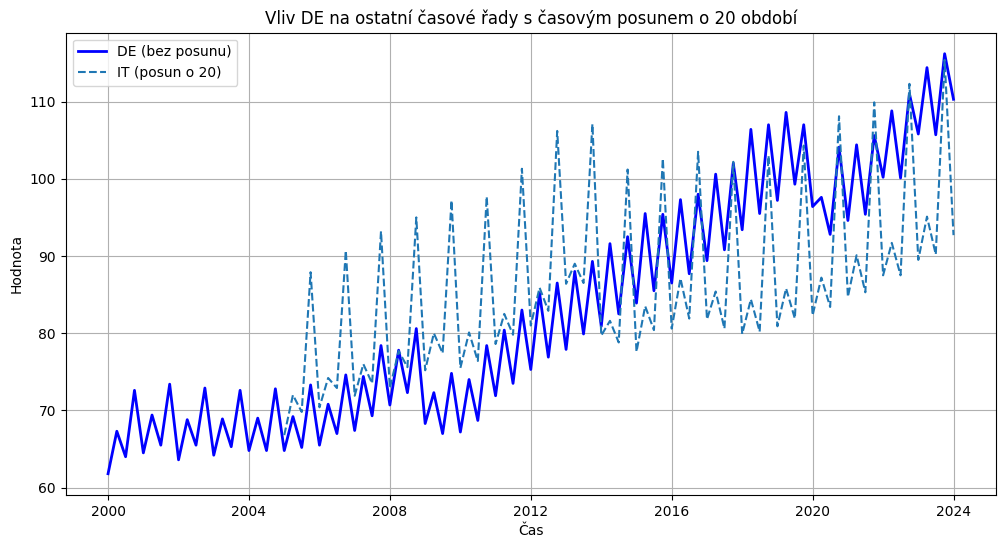

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# Funkce pro vykreslení jedné časové řady bez posunu a ostatních řad s posunem
def plot_lagged_comparison(data, reference_geo, other_geos, lag=20):
    plt.figure(figsize=(12, 6))
    
    # Původní časová řada pro referenční geografickou oblast (např. DE)
    plt.plot(data.index, data[reference_geo], label=f'{reference_geo} (bez posunu)', color='blue', linewidth=2)
    
    # Ostatní časové řady s aplikovaným posunem
    for geo in other_geos:
        shifted_series = data[geo].shift(lag)
        plt.plot(data.index, shifted_series, label=f'{geo} (posun o {lag})', linestyle='--')
    
    plt.title(f'Vliv {reference_geo} na ostatní časové řady s časovým posunem o {lag} období')
    plt.xlabel('Čas')
    plt.ylabel('Hodnota')
    plt.legend()
    plt.grid(True)
    plt.show()

# Příklad použití funkce
reference_geo = 'DE'  # Referenční časová řada (bez posunu)
other_geos = ['IT']  # Ostatní časové řady s aplikovaným posunem

# Vykreslení porovnání DE s posunutými IT a FR
plot_lagged_comparison(pivot_data, reference_geo, other_geos, lag=20)

In [118]:
from statsmodels.tsa.stattools import grangercausalitytests

# Funkce pro provedení Grangerova testu
def granger_causality_test(data, max_lag=20):
    results = {}
    
    # Pro každou dvojici časových řad provedeme Grangerův test
    geos = data.columns
    for geo1 in geos:
        for geo2 in geos:
            if geo1 != geo2:
                print(f"\nTestování, zda {geo1} Grangerovsky způsobuje {geo2}")
                test_result = grangercausalitytests(data[[geo2, geo1]].dropna(), max_lag, verbose=True)
                results[(geo1, geo2)] = test_result
    
    return results

# Použití Grangerova testu na časové řady DE, IT, FR
granger_results = granger_causality_test(pivot_data, max_lag=20)


Testování, zda DE Grangerovsky způsobuje IT

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.9640 , p=0.0000  , df_denom=93, df_num=1
ssr based chi2 test:   chi2=25.7693 , p=0.0000  , df=1
likelihood ratio test: chi2=22.8269 , p=0.0000  , df=1
parameter F test:         F=24.9640 , p=0.0000  , df_denom=93, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=81.9495 , p=0.0000  , df_denom=90, df_num=2
ssr based chi2 test:   chi2=173.0045, p=0.0000  , df=2
likelihood ratio test: chi2=98.5271 , p=0.0000  , df=2
parameter F test:         F=81.9495 , p=0.0000  , df_denom=90, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=123.1804, p=0.0000  , df_denom=87, df_num=3
ssr based chi2 test:   chi2=399.2743, p=0.0000  , df=3
likelihood ratio test: chi2=155.8304, p=0.0000  , df=3
parameter F test:         F=123.1804, p=0.0000  , df_denom=87, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based